# MCB-IB Phylogenetics practical

Here we will examine the phylogenetic relationships between great apes.  The data set includes two sequences from each of 12 populations: 2 humans, 3 gorilla, 1 bonobo and 4 chimpanzee and 2 orang-utan.

We will use the internal BioPython.Phylo module functions to explore some basic properties, then run the more powerful iqtree software to explore maximum likelihood calculations.

A side trip into the iqtree manual will demonstrate, we hope, that you have acquired enough background to understand at least in part a rich range of options.

Finally we will investigate incomplete lineage sorting (ILS) in this data set, and in a corresponding data set simulated by iqtree from its best fit model.

### First make sure external libraries are installed

In [1]:
%%sh
pip install biopython pandas seaborn scipy

### Load what we need

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Phylo.Consensus import *

/var/folders/6s/khlvwph13yj8lkpm9gj899400000gn/T/ipykernel_72699/2173263033.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Open MSA

In [57]:
great_apes_msa = AlignIO.read("great_apes.phy", format="phylip-relaxed")

## Convert to a dictionary from ape name to pair of sequences
For each individual there are two entries, e.g. Pongo_abelii-1 and Pongo_abelii-2.  We want to remove the final two characters.

In [58]:
great_ape_names = sorted(set([seq.id[:-2] for seq in great_apes_msa.alignment.sequences]))

display(great_ape_names)

['Gorilla_beringei_graueri',
 'Gorilla_gorilla_dielhi',
 'Gorilla_gorilla_gorilla',
 'Homo_sapiens_afr',
 'Homo_sapiens_nonAfr',
 'Pan_paniscus',
 'Pan_troglodytes_ellioti',
 'Pan_troglodytes_schweinfurthii',
 'Pan_troglodytes_troglodytes',
 'Pan_troglodytes_verus',
 'Pongo_abelii',
 'Pongo_pygmaeus']

In [59]:
name_to_sequences = {}

for name in great_ape_names:
    name_to_sequences[name] = []

for sequence in great_apes_msa.alignment.sequences:
    name = sequence.id[:-2]
    
    name_to_sequences[name].append(sequence.seq)
    

In [60]:
display(name_to_sequences)

{'Gorilla_beringei_graueri': [Seq('tagagggggcagccgcacacgggatcaggcggagggacgcggctggccgccgcc...ctg'),
  Seq('tagagggggcagccgcacacgggatcaggcggagggacgcggctggccgccgcc...ctg')],
 'Gorilla_gorilla_dielhi': [Seq('tagagggggcagccgcacacgggatcaggcggagggacgcggctggccgccgcc...ctg'),
  Seq('tagagggggcagccgcacacgggatcaggcggagggacgcggctggccgccgcc...ctg')],
 'Gorilla_gorilla_gorilla': [Seq('tagagggggcagccgcacacgggatcaggcggagggacgcggctggccgccgcc...ctg'),
  Seq('tagagggggcagccgcacacgggatcaggcggagggacgcggctggccgccgcc...ctg')],
 'Homo_sapiens_afr': [Seq('tagagggggcagccgcacacgggatcaggcggagggacgcggctggccgccgcc...ctg'),
  Seq('tagagggggcagccgcacacgggatcaggcggagggacgcggctggccgccgcc...ctg')],
 'Homo_sapiens_nonAfr': [Seq('tagagggggcagccgcacacgggatcaggcggagggacgcggctggccgccgcc...ctg'),
  Seq('tagagggggcagccgcacacgggatcaggcggagggacgcggctggccgccgcc...ctg')],
 'Pan_paniscus': [Seq('tagagggggcagccgcacacgggatcaggcggagggacgcggctggccgccgcc...ctg'),
  Seq('tagagggggcagccgcacacgggatcaggcggagggacgcggctggccgccgcc...ctg')],
 '

# Calculate pairwise divergences within species

In [61]:
for name in great_ape_names:
    seq1 = name_to_sequences[name][0]
    seq2 = name_to_sequences[name][1]
    
    seq_length = len(seq1)
#     n_diffs = 0
#     for i in range(seq_length):
#         if seq1[i] != seq2[i]:
#             n_diffs += 1
            
    theta = n_diffs/seq_length
            
    print(f"{name:40}{n_diffs}\t{seq_length}\t{theta}")

Gorilla_beringei_graueri                23	18254	0.0012599978086994632
Gorilla_gorilla_dielhi                  23	18254	0.0012599978086994632
Gorilla_gorilla_gorilla                 23	18254	0.0012599978086994632
Homo_sapiens_afr                        23	18254	0.0012599978086994632
Homo_sapiens_nonAfr                     23	18254	0.0012599978086994632
Pan_paniscus                            23	18254	0.0012599978086994632
Pan_troglodytes_ellioti                 23	18254	0.0012599978086994632
Pan_troglodytes_schweinfurthii          23	18254	0.0012599978086994632
Pan_troglodytes_troglodytes             23	18254	0.0012599978086994632
Pan_troglodytes_verus                   23	18254	0.0012599978086994632
Pongo_abelii                            23	18254	0.0012599978086994632
Pongo_pygmaeus                          23	18254	0.0012599978086994632


These numbers look a bit lower than we expect, e.g. Homo_sapiens_afr should be ~0.0012 and nonAfr ~0.0008. This is most likely a consequence of how these sites were chosen. We will proceed regardless. 

# Calculate the distance matrix

In [62]:
def view_distance_matrix(distance_matrix, return_matrix=False):
    n_names = len(distance_matrix)
    D = np.zeros((n_names, n_names))
    for i in range(n_names):
        D[i,:i+1] = distance_matrix.matrix[i]
    names = np.array(distance_matrix.names).astype(str)
    df = pd.DataFrame(data=D, index=names, columns=names)
    
    if return_matrix:
        return df
    
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(df, vmin=0, square=True, ax=ax)
    ax.set_title("Distance matrix")
    
#     sns.clustermap(df)
    
    

In [63]:
print(DistanceCalculator.dna_models)

['benner22', 'benner6', 'benner74', 'blastn', 'dayhoff', 'feng', 'genetic', 'gonnet1992', 'hoxd70', 'johnson', 'jones', 'levin', 'mclachlan', 'mdm78', 'megablast', 'blastn', 'rao', 'risler', 'schneider', 'str', 'trans']


In [64]:
distance_matrix = DistanceCalculator('identity').get_distance(great_apes_msa)

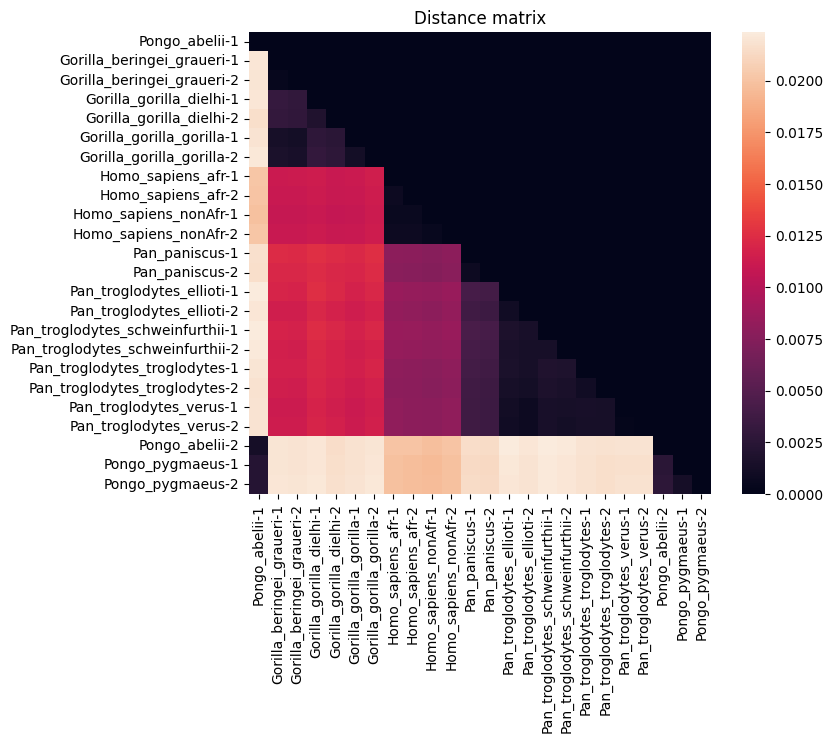

In [65]:
view_distance_matrix(distance_matrix)


# Build a tree

## Neighbor joining

In [66]:
NJ_constructor = DistanceTreeConstructor(DistanceCalculator('identity'), "nj")

In [67]:
NJ_tree = NJ_constructor.build_tree(great_apes_msa)

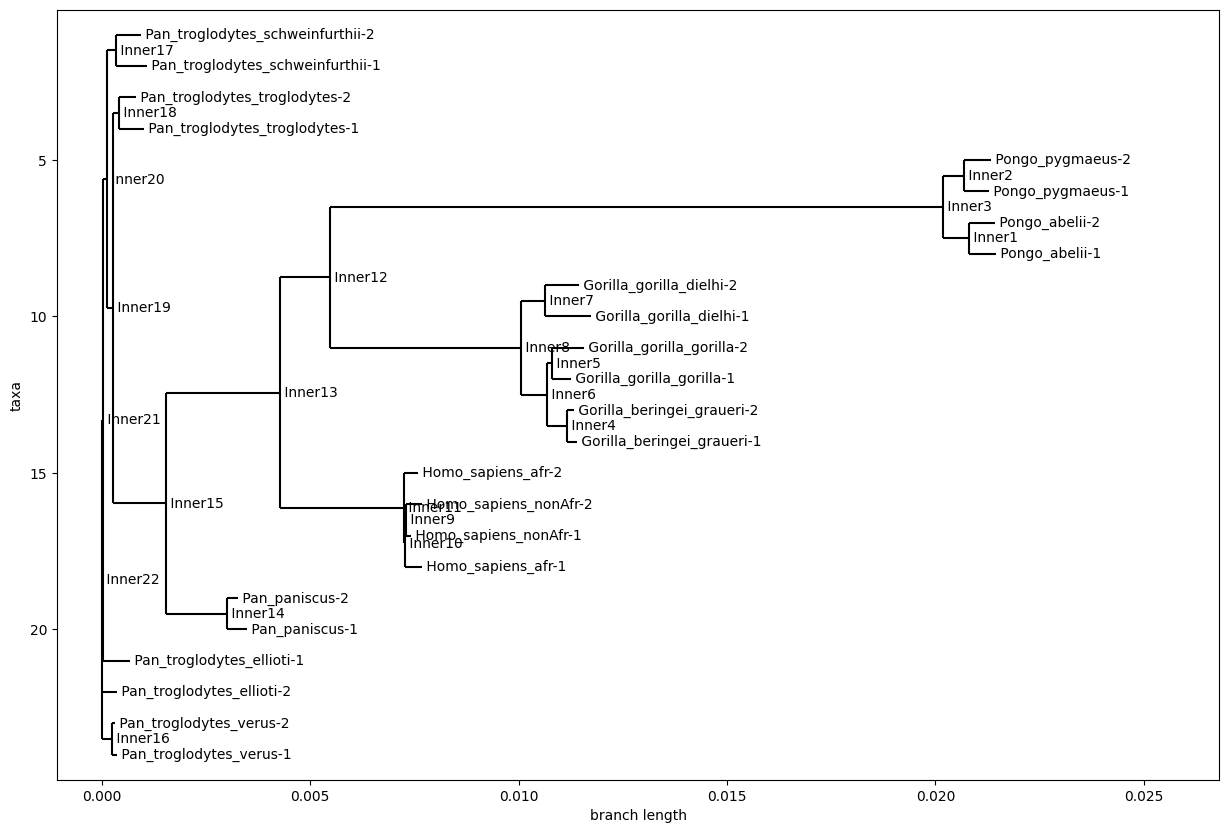

In [68]:
fig, ax = plt.subplots(figsize=(15,10))
Phylo.draw(NJ_tree, axes=ax)

Why does this tree look different from the one we started with?

Are all the sequence pairs from the same population neighbours?  Why might they not be?

## UPGMA

In [69]:
UPGMA_constructor = DistanceTreeConstructor(DistanceCalculator('identity'), 'upgma')

In [70]:
UPGMA_tree = UPGMA_constructor.build_tree(great_apes_msa)

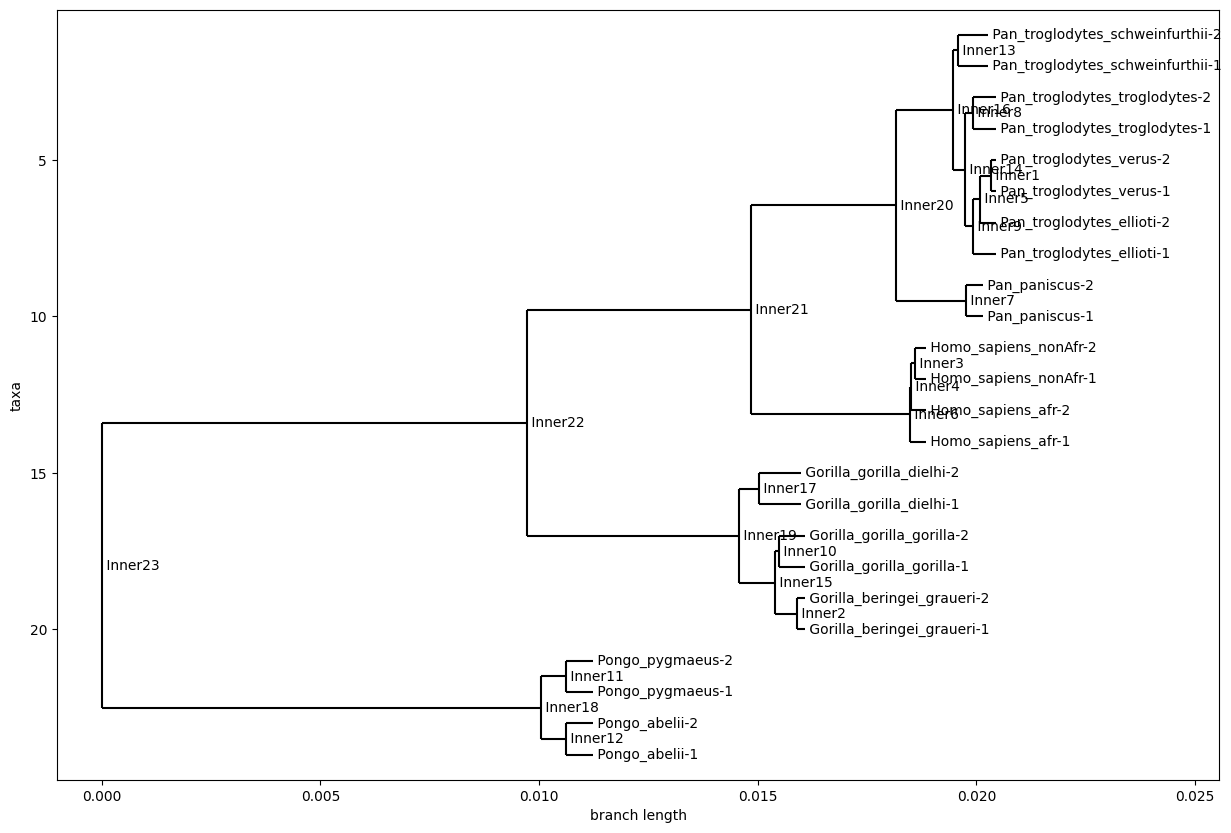

In [71]:
fig, ax = plt.subplots(figsize=(15,10))
Phylo.draw(UPGMA_tree, axes=ax)

# Bootstrapping

In [72]:
bootstrap_alns = list(bootstrap(great_apes_msa, 10))

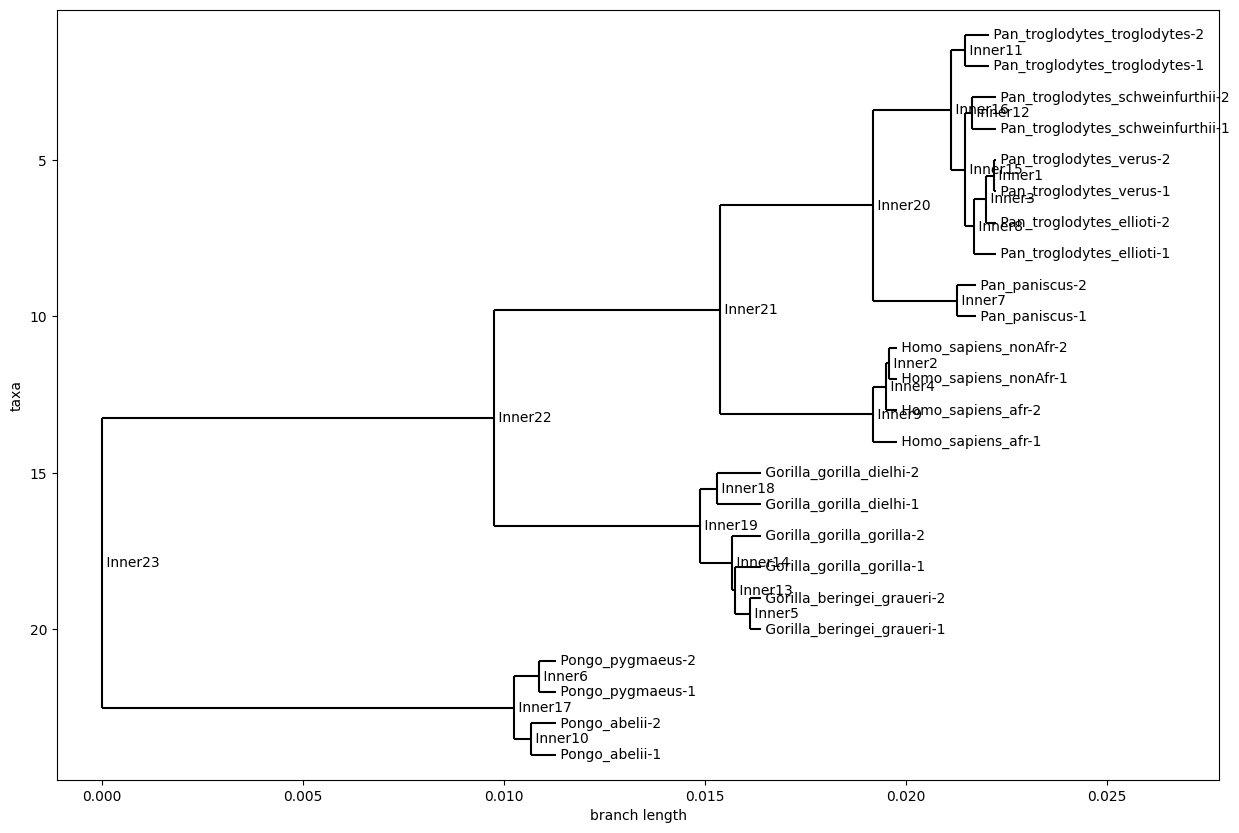

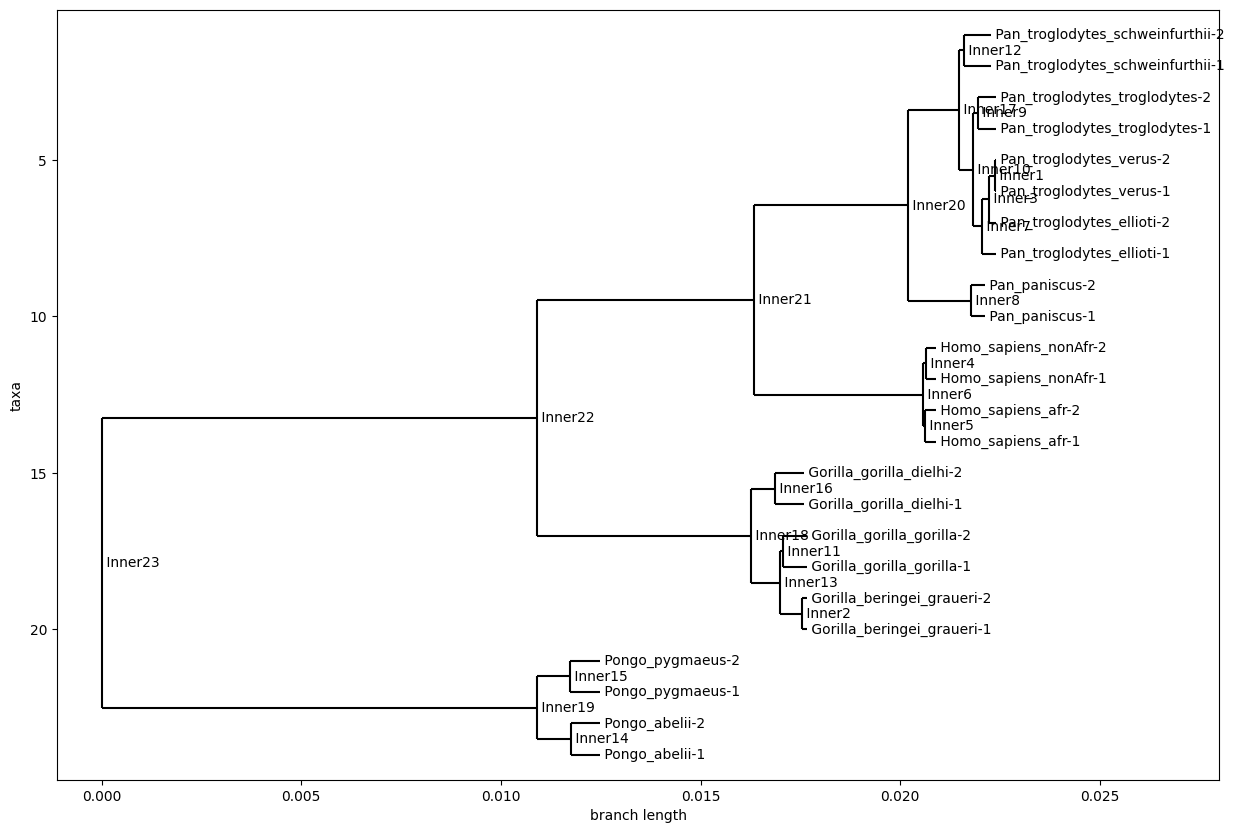

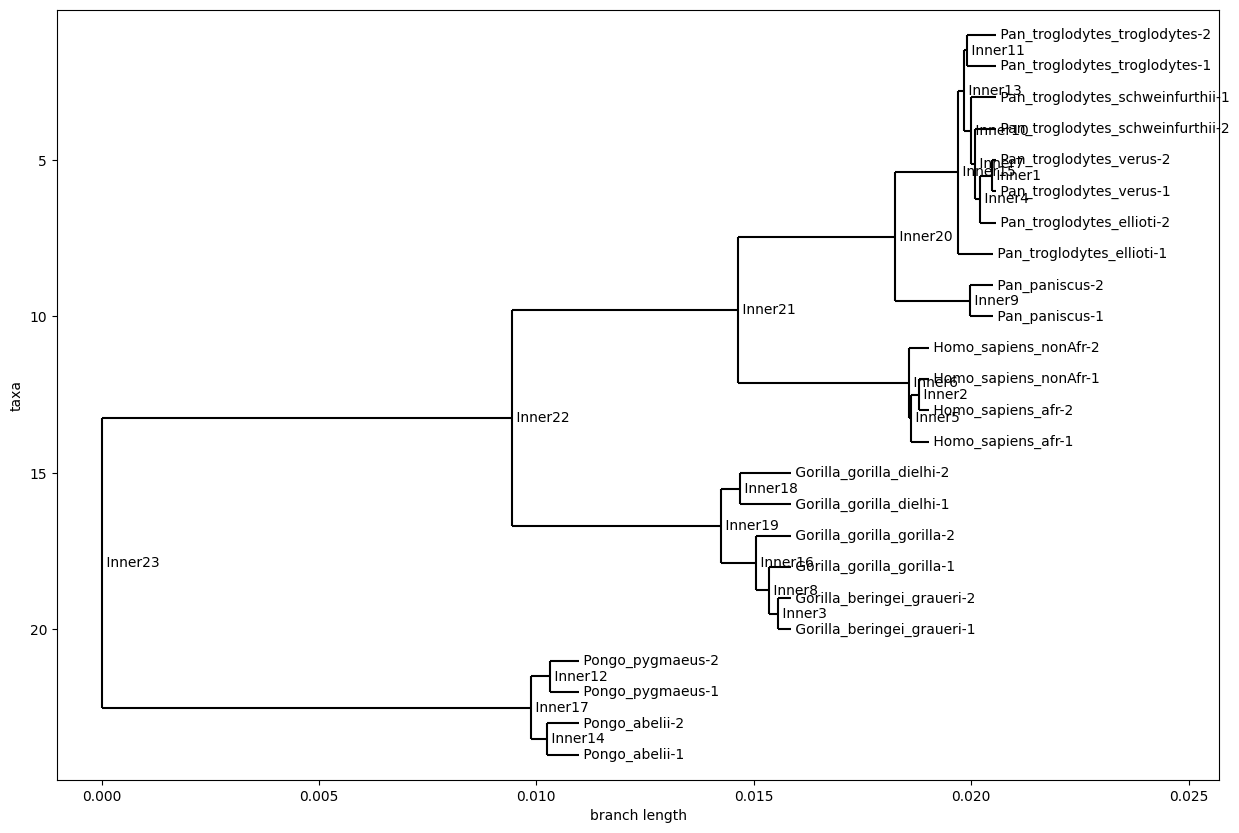

In [73]:
for bootstrap_aln in bootstrap_alns[:3]:
    fig, ax = plt.subplots(figsize=(15,10))
    Phylo.draw(UPGMA_constructor.build_tree(bootstrap_aln), axes=ax)


### Build on a shorter segment

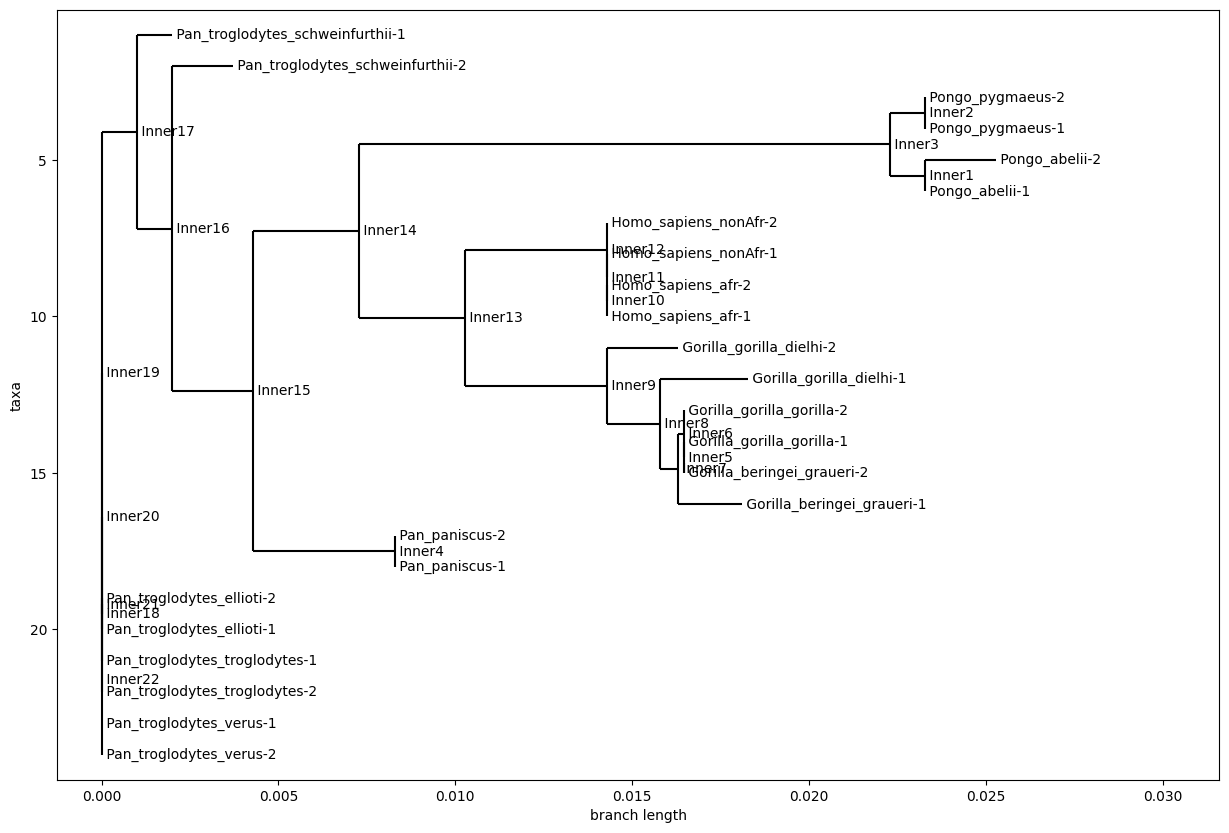

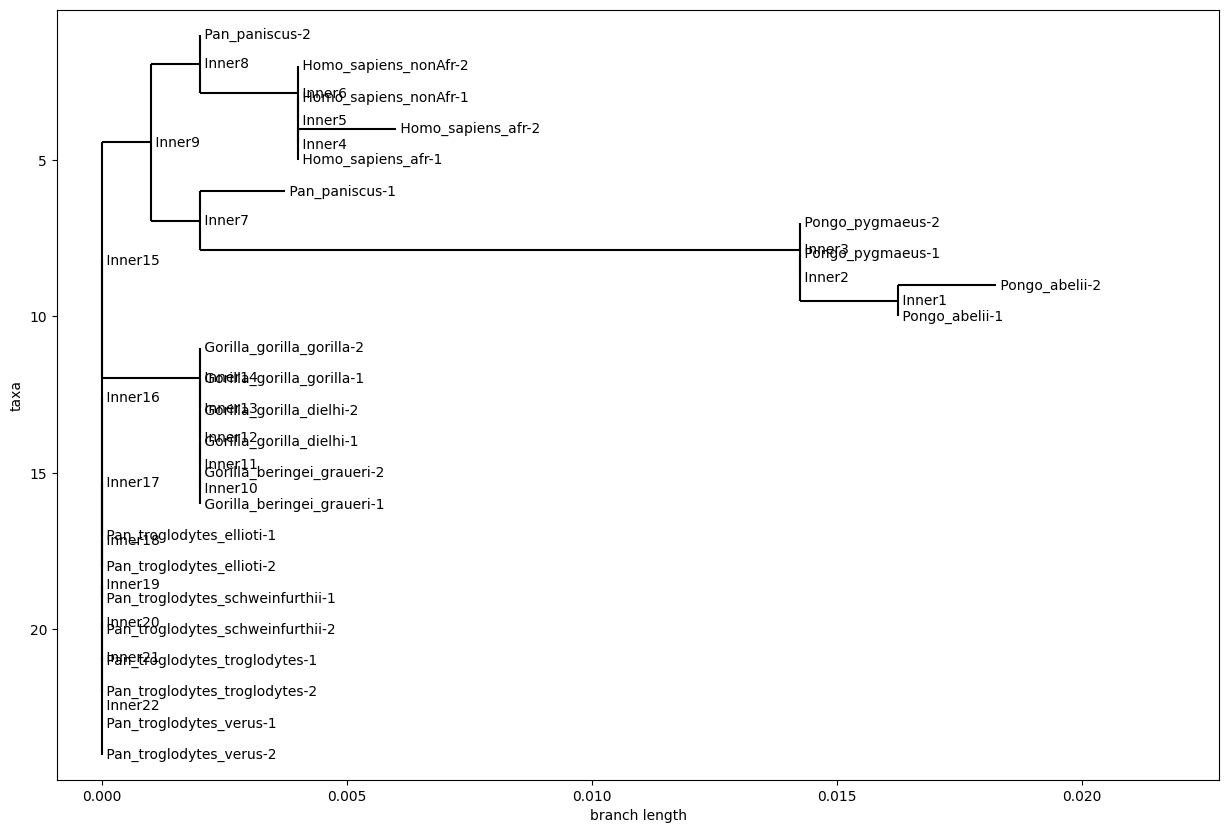

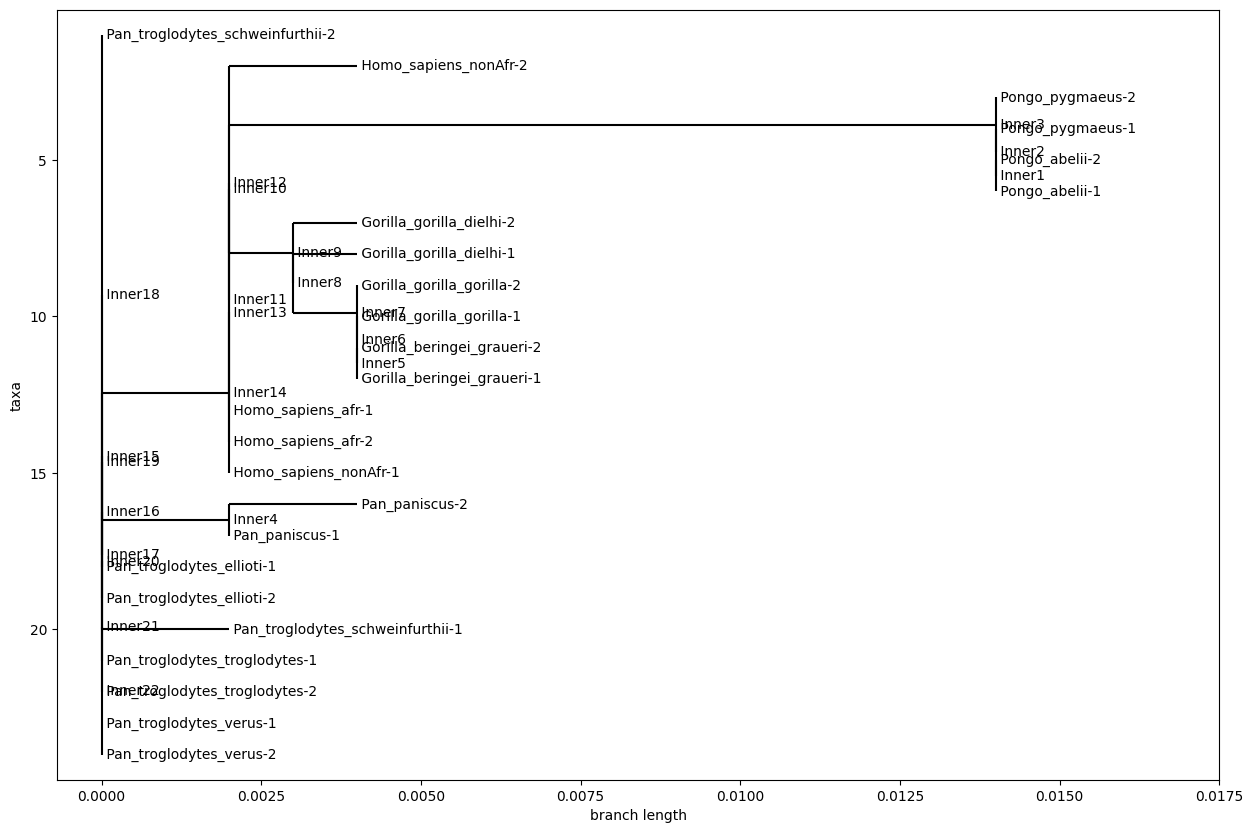

In [74]:
for bootstrap_aln in bootstrap_alns[:3]:
    shorter_aln = bootstrap_aln[:, :500]
    
    fig, ax = plt.subplots(figsize=(15,10))
    Phylo.draw(NJ_constructor.build_tree(shorter_aln), axes=ax)


## Run IQtree

In [75]:
%%sh
./iqtree2 -s ./great_apes.phy -B 1000 --redo

IQ-TREE multicore version 2.2.2.6 COVID-edition for Mac OS X 64-bit built May 27 2023
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Host:    dhcp-10-249-0-115.eduroam.wireless.private.cam.ac.uk (SSE4.2, 16 GB RAM)
Command: ./iqtree2 -s ./great_apes.phy -B 1000 --redo
Seed:    150904 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Wed Feb 14 12:50:53 2024
Kernel:  SSE2 - 1 threads (10 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 10 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file ./great_apes.phy ... Phylip format detected
Alignment most likely contains DNA/RNA sequences
Constructing alignment: done in 0.0115609 secs using 69.22% CPU
Alignment has 24 sequences with 18254 columns, 280 distinct patterns
597 parsimony-informative, 103 singleton sites, 17554 constant s

401  HKY+F+R2      31435.585    51  62973.170    62973.461    63371.589
402  HKY+F+R3      31435.513    53  62977.026    62977.340    63391.069
420  K2P+I         31602.838    47  63299.677    63299.925    63666.847
423  K2P+R2        31592.319    48  63280.638    63280.896    63655.620
424  K2P+R3        31592.314    50  63284.627    63284.907    63675.234
442  F81+F+I       31767.853    49  63633.705    63633.975    64016.500
445  F81+F+R2      31759.945    50  63619.891    63620.171    64010.497
446  F81+F+R3      32043.718    52  64191.436    64191.739    64597.667
464  JC+I          31920.736    46  63933.473    63933.710    64292.831
467  JC+R2         31912.732    47  63919.464    63919.711    64286.634
468  JC+R3         32196.372    49  64490.743    64491.013    64873.538
Akaike Information Criterion:           TIM2+F+R2
Corrected Akaike Information Criterion: TIM2+F+R2
Bayesian Information Criterion:         TN+F+R2
Best-fit model: TN+F+R2 chosen according to BIC

All model i

Iteration 80 / LogL: -31437.260 / Time: 0h:0m:1s (0h:0m:0s left)
Optimizing NNI: done in 0.0174589 secs using 99.33% CPU
Optimizing NNI: done in 0.021117 secs using 99.3% CPU
Optimizing NNI: done in 0.0143061 secs using 99.4% CPU
Optimizing NNI: done in 0.0182471 secs using 99.61% CPU
Optimizing NNI: done in 0.0149121 secs using 99.43% CPU
Optimizing NNI: done in 0.012116 secs using 99.64% CPU
Optimizing NNI: done in 0.015069 secs using 98.85% CPU
Optimizing NNI: done in 0.0105159 secs using 99.34% CPU
Optimizing NNI: done in 0.0132861 secs using 99.82% CPU
Optimizing NNI: done in 0.012913 secs using 99.57% CPU
Iteration 90 / LogL: -31403.801 / Time: 0h:0m:1s (0h:0m:0s left)
Optimizing NNI: done in 0.014621 secs using 99.79% CPU
Optimizing NNI: done in 0.0169129 secs using 98.99% CPU
Optimizing NNI: done in 0.0179269 secs using 99.53% CPU
Optimizing NNI: done in 0.0145519 secs using 99.41% CPU
Optimizing NNI: done in 0.013588 secs using 99.23% CPU
Optimizing NNI: done in 0.0186481 secs

Estimate model parameters (epsilon = 0.010)
1. Initial log-likelihood: -31403.800
2. Current log-likelihood: -31403.717
3. Current log-likelihood: -31403.634
4. Current log-likelihood: -31403.558
5. Current log-likelihood: -31403.488
6. Current log-likelihood: -31403.425
7. Current log-likelihood: -31403.368
8. Current log-likelihood: -31403.316
9. Current log-likelihood: -31403.270
10. Current log-likelihood: -31403.229
11. Current log-likelihood: -31403.192
12. Current log-likelihood: -31403.160
13. Current log-likelihood: -31403.131
14. Current log-likelihood: -31403.106
15. Current log-likelihood: -31403.083
16. Current log-likelihood: -31403.064
17. Current log-likelihood: -31403.047
18. Current log-likelihood: -31403.032
19. Current log-likelihood: -31403.020
20. Current log-likelihood: -31403.009
Optimal log-likelihood: -31402.999
Rate parameters:  A-C: 1.00000  A-G: 9.68752  A-T: 1.00000  C-G: 1.00000  C-T: 4.61175  G-T: 1.00000
Base frequencies:  A: 0.216  C: 0.308  G: 0.233  

## Open IQtree outputs

### Maximum likelihood tree

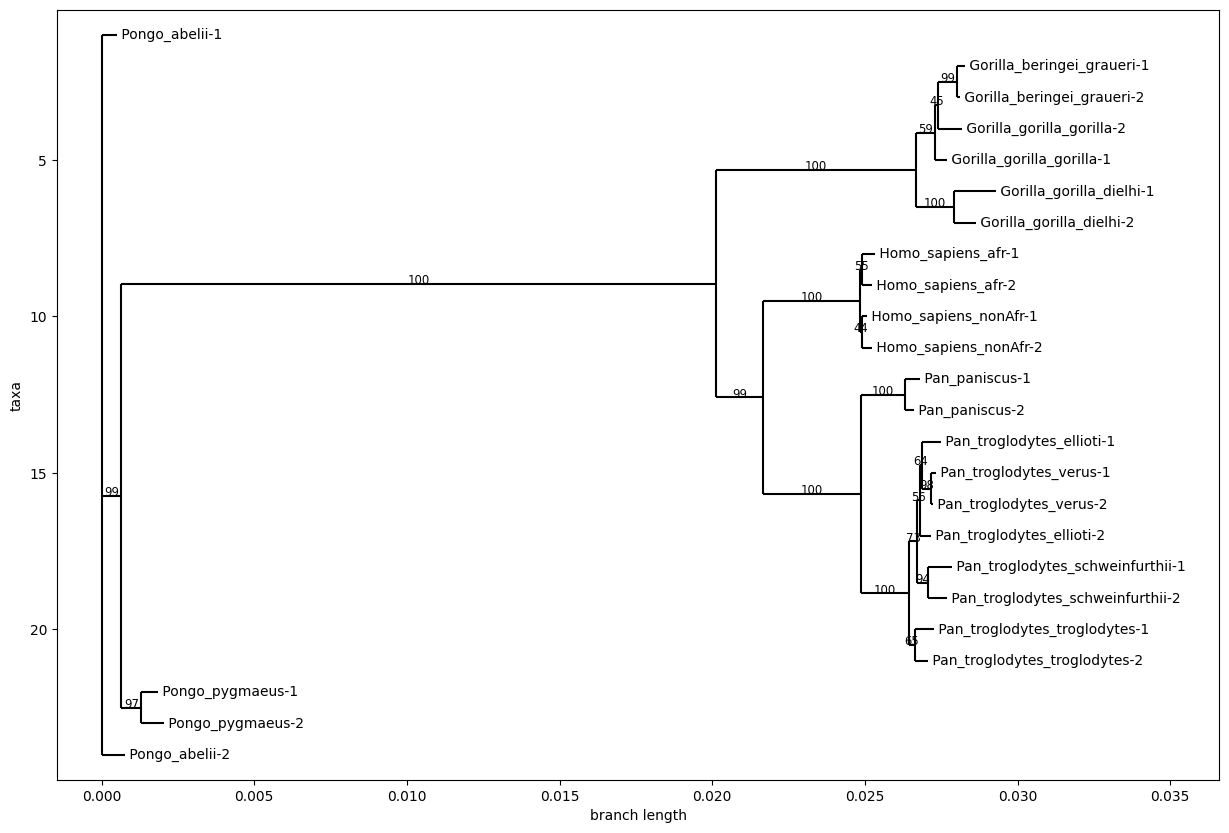

In [76]:
fig, ax = plt.subplots(figsize=(15,10))
Phylo.draw(Phylo.read("./great_apes.phy.treefile", "newick"), axes=ax)

Is this the same as the NJ and UPGMA trees?  What is different?

Not all the bootstrap values are 100%, even with nearly 20,000 sites.  Why is that?

### See ML distances

In [77]:
mat = np.array([line.strip().split()[1:] for line in open("./great_apes.phy.mldist").readlines()[1:]]).astype(float)
    

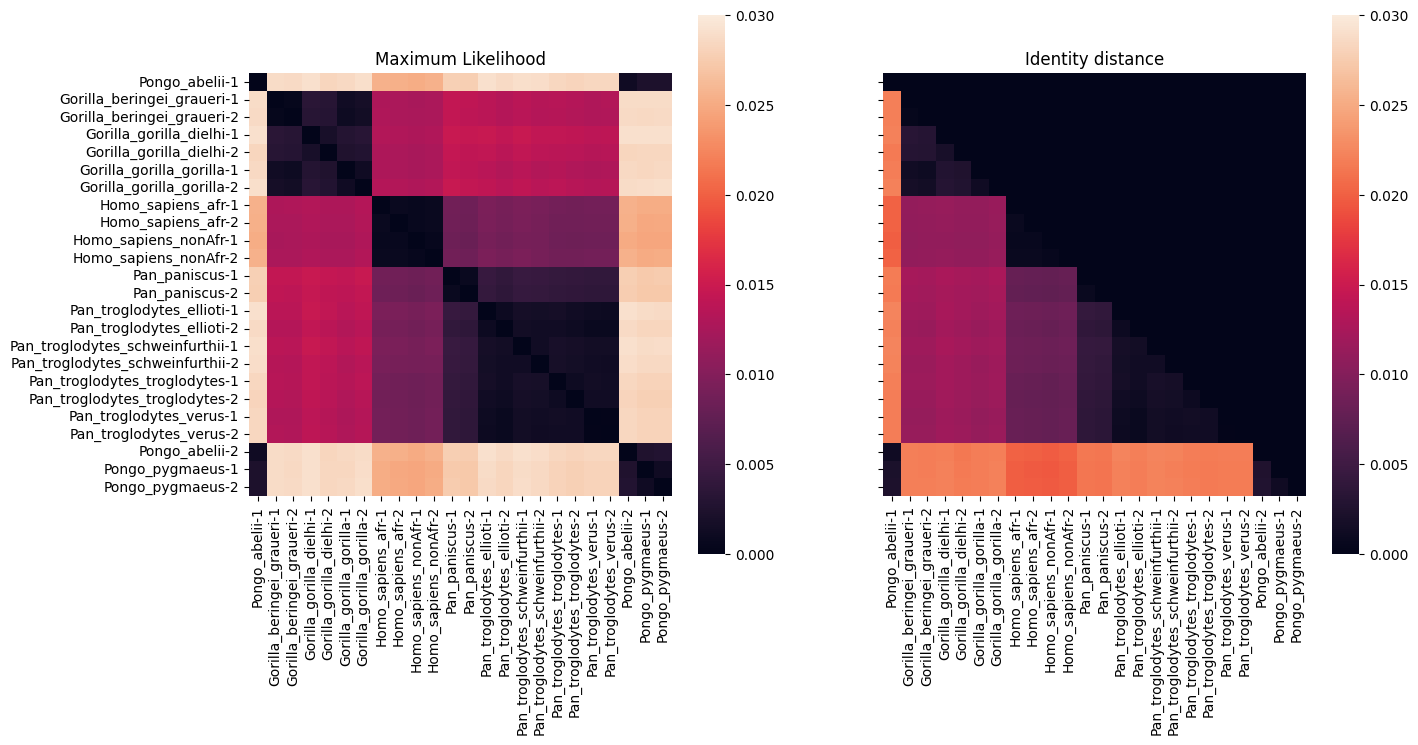

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(15,7), sharey=True, sharex=True)

sns.heatmap(
    mat, 
    square=True, 
    ax=ax[0],
    vmin=0,
    vmax=0.03,
)
ax[0].set_title("Maximum Likelihood");

sns.heatmap(
    view_distance_matrix(distance_matrix, return_matrix=True), 
    square=True, 
    ax=ax[1],
    vmin=0,
    vmax=0.03,
)
ax[1].set_title("Identity distance");
